This notebook performs the synthesis using our proposed synthesization approach applied to the South Korean COVID-19 Patient data. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
X = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

Number of locations from deceased individuals.

In [3]:
np.sum(X.state)

55

In [4]:
np.mean(X.sex)

0.4620083432657926

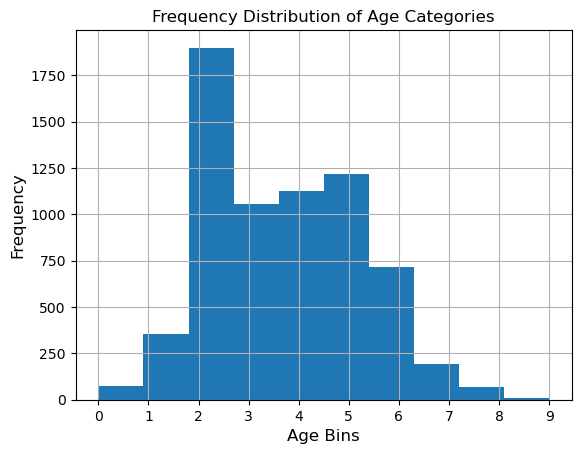

In [5]:
ax = X.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

Testing logistic and multinomial logistic regression synthesizers.

In [6]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [7]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_sex_": (0.001, 3),
            "C_age_": (0.001, 3),
            "C_state_": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [8]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [9]:
optimization_results = [optimize_models_mn(train_data=X, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.2286   | 2.23      | 0.68      | 1.928     | 178.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.1529   | 2.222     | 2.164     | 0.8867    | 110.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.2861   | 0.5221    | 2.436     | 2.548     | 58.99     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.183    | 0.7125    | 1.376     | 0.6875    | 48.58     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.2525   | 2.948     | 2.942     | 2.205     | 88.17     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 6         | -0.203    | 2.081     | 2.532     | 1.068     | 110.1     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.1976   | 2.329     | 2.029     | 0.7509    | 110.6     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.2647   | 2.142     | 2.07      | 0.9904    | 110.3     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1131   | 0.8349    | 1.203     | 0.3184    | 29.35     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.1909   | 2.128     | 0.6103    | 0.3872    | 133.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.2119   | 1.783     | 1.123     | 2.265     | 27.18     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.2216   | 1.341     | 1.132     | 2.848     | 87.31     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.1289   | 0.7528    | 0.7346    | 0.4276    | 49.72     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.2167   | 1.315     | 1.656     | 1.59      | 36.28     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.162    | 0.9045    | 1.061     | 0.2818    | 129.6     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.2733   | 0.62      | 1.624     | 1.182     | 173.7     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.1944   | 2.369     | 0.7901    | 0.5949    | 198.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.2597   | 1.36      | 1.138     | 1.091     | 51.26     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.2303   | 0.7241    | 2.965     | 2.631     | 48.82     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1895   | 2.412     | 1.497     | 0.5623    | 163.3     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.2212   | 1.492     | 0.5222    | 1.871     | 151.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1938   | 1.345     | 1.038     | 0.5574    | 146.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.1994   | 2.713     | 2.563     | 2.663     | 38.75     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.2342   | 0.5597    | 0.6877    | 2.212     | 30.74     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.2364   | 0.5975    | 0.6157    | 1.362     | 157.3     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.2355   | 0.5909    | 1.162     | 2.206     | 109.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.1514   | 0.1703    | 2.232     | 0.8526    | 139.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1838   | 2.659     | 1.635     | 0.3224    | 148.0     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.2873   | 1.21      | 1.465     | 1.402     | 189.3     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.1622   | 1.469     | 2.998     | 1.259     | 42.01     |
Final Result:  {'target': -0.1130789101645969, 'params': {'C_age_': 0.8349435666001503, 'C_sex_': 1.2032949192145594, 'C_state_': 0.31836961108979706, 'num_components_': 29.34692071030441}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.2358   | 2.455     | 2.623     | 1.256     | 95.03     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.1995   | 0.3865    | 0.3158    | 1.939     | 193.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.2261   | 0.873     | 0.2011    | 1.478     | 86.85     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.106    | 0.6546    | 2.504     | 0.5472    | 89.95     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -0.04123  | 0.929     | 2.961     | 0.1235    | 66.4      |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.3449   | 2.803     | 0.7078    | 1.938     | 10.39     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.1128   | 0.9509    | 2.993     | 1.903     | 196.7     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.1714   | 1.507     | 0.05996   | 0.8827    | 33.59     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.2805   | 2.397     | 2.064     | 1.545     | 112.4     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.2259   | 1.357     | 0.7334    | 1.947     | 116.6     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.2114   | 1.73      | 0.5097    | 2.573     | 128.8     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.1945   | 0.5411    | 2.506     | 0.613     | 89.89     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.1174   | 1.677     | 0.2142    | 0.6219    | 33.8      |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.2435   | 1.068     | 2.142     | 2.85      | 66.14     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.1826   | 0.9228    | 2.218     | 2.23      | 79.18     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.09806  | 1.968     | 0.08499   | 0.4777    | 125.1     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.2089   | 0.4578    | 1.758     | 2.202     | 108.2     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.2301   | 0.5253    | 2.544     | 2.066     | 177.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.2316   | 2.818     | 1.134     | 0.9248    | 92.67     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.1865   | 1.191     | 0.5702    | 2.751     | 137.1     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.2649   | 2.67      | 2.171     | 2.091     | 147.1     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 22        | -0.001685 | 0.8081    | 2.237     | 0.0687    | 145.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.1538   | 1.7       | 0.1419    | 2.998     | 128.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.2079   | 2.18      | 2.33      | 0.8274    | 199.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.1555   | 0.2763    | 0.4041    | 1.921     | 167.9     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.2315   | 0.7096    | 0.3409    | 0.3692    | 107.2     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.1564   | 2.085     | 1.331     | 0.535     | 149.5     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1213   | 2.893     | 2.979     | 0.6242    | 146.0     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.05141  | 2.225     | 2.432     | 0.117     | 180.1     |


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.1881   | 1.368     | 0.8366    | 2.655     | 179.2     |
Final Result:  {'target': -0.0016846208663776829, 'params': {'C_age_': 0.8080666035314793, 'C_sex_': 2.236760850003377, 'C_state_': 0.06869830288983586, 'num_components_': 145.89731614289823}}


In [10]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

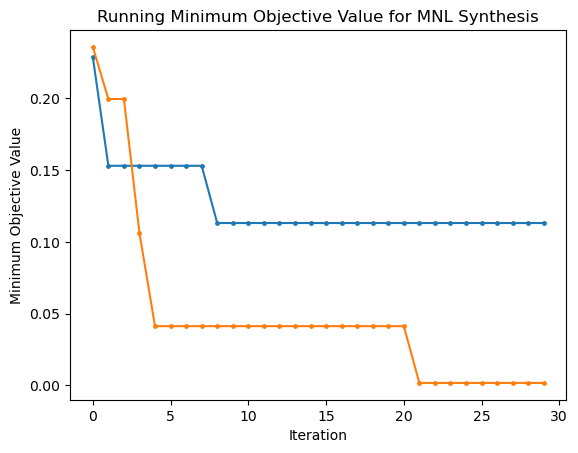

In [11]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [12]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [13]:
best_params

{'target': -0.0016846208663776829,
 'params': {'C_age_': 0.8080666035314793,
  'C_sex_': 2.236760850003377,
  'C_state_': 0.06869830288983586,
  'num_components_': 145.89731614289823}}

Generate 20 synthetic data sets.

In [36]:
full_ratios, full_sXs, GMM = train_models_mn(train_data=X,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for MNL, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [37]:
np.mean(full_ratios)

0.942903899574058

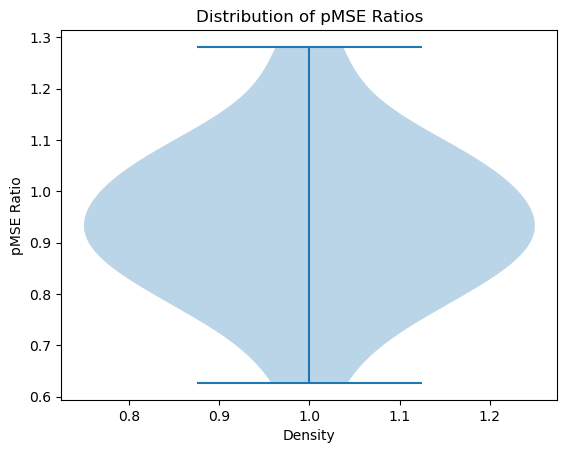

In [38]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [39]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

***

Now apply the attribute disclosure prevention algorithm.

Based on publicly available data from the World Health Organization, we use the total number of confirmed COVID-19 cases (9,583) and total number of deaths (152) in South Korea as of March 23, 2020 to calculate the prior probability $p(S_j = 1 | x_j^q, b) = 152/9583 \approx 0.016$ and $p(S_j = 0 | x_j^q, b) = 1 - 0.016 = 0.984$.

In [40]:
prior = 152/9583

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the correct disease status based on the synthetic data. This is a relatively large increase. For example, this means going from 0.016 under the prior to no more than 0.16 under the updated probability.

In [41]:
c = 10

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [43]:
deltas = np.linspace(0.001, 1, 5)

In [47]:
ad_sXs = [attribute_disclosure_reduction_sk(original_data=X, synthetic_data=X, mixture_model=GMM, 
                                            deltas=deltas, c=c, prior_prob=prior) for X in full_sXs]

Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 2 completed.
Record 1678 completed.
Record 3356 completed.
Record 5034 completed.
Full anonymization loop 1 completed.
Record 1678 completed.
Record 3356 completed.


In [48]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)